# Predicting Treatment Effects with ReCoN

This tutorial demonstrates how to use ReCoN to **predict the cell-type-specific effects of a molecular treatment**. You will learn how to:

1. Build a multilayer network integrating GRNs and cell-cell communication
2. Select a molecule (ligand) to perturb
3. Predict direct effects (on receptor-expressing cells) and indirect effects (via cell-cell signaling)
4. Compare predicted responses across cell types

**Use case**: Given a therapeutic molecule (e.g., a ligand or antibody), predict which genes will be affected in each cell type and identify cell-type-specific responses.

In [2]:
import numpy as np
import scanpy as sc  # single cell data
import pandas as pd  # data manipulation
import liana as li  # cell communication
import recon  # multilayer and perturbation prediction
import recon.data

---

## Setup

ReCoN uses single-cell RNA-seq data to infer cell-cell communication and gene regulatory networks.

```{tip}
The example data for this tutorial can be downloaded from the [ReCoN repository](https://github.com/cantinilab/ReCoN/tree/main/data/perturbation_tuto).
```

```{note}
**Required packages**

This tutorial requires `liana` for cell-cell communication inference:
- Install with: `pip install liana`
```

In [3]:
rna = sc.read_h5ad("./data/perturbation_tuto/rna.h5ad")

Let's check what cell types are present in this dataset

In [4]:
rna.obs["celltype"].unique().tolist()[:5]

['B_cell', 'ILC', 'Macrophage', 'MigDC', 'Monocyte']

---

## Build the Multilayer Network

ReCoN integrates three main components:
1. **Gene Regulatory Networks (GRNs)** - TF → target gene relationships
2. **Cell-Cell Communication (CCC)** - Ligand-receptor interactions between cell types
3. **Receptor-Gene Links** - How receptors connect to intracellular signaling

### 1. Import Gene Regulatory Network

You can either generate GRNs directly with ReCoN or import a previously generated one.

```{tip}
If you wish to generate GRNs directly with ReCoN, please follow [Tutorial 4: GRN Inference with HuMMuS](4.recon_hummus.ipynb).
```

```{warning}
GRN inference requires a **Python 3.10** conda environment due to CellOracle dependencies. See the [Installation guide](../recon_explained/get_ready.rst) for details.
```

In [5]:
grn_path = "./data/perturbation_tuto/grn.csv"
grn = pd.read_csv(grn_path, index_col=0)
grn = grn.sort_values(by="weight", ascending=False)[:500_000]
grn["source"] = grn["source"].str.capitalize()
grn["target"] = grn["target"].str.capitalize()
grn.head(3)

,target,source,weight
0,Pax5,Mbd1,0.000095
2,Pax5,Smad5,0.000092
1,Pax5,Smad1,0.000092


### 2. Compute Cell-Cell Communication

The cell-cell communication is inferred through LIANA+, an external package dedicated to this task.

```{tip}
For more information, check the [LIANA+ documentation](https://liana-py.readthedocs.io/en/latest/).
```

In [6]:
li.method.cellphonedb(rna, 
            # NOTE by default the resource uses HUMAN gene symbols
            resource_name="mouseconsensus",
            expr_prop=0.00,
            use_raw=False,
            groupby="celltype",
            verbose=True, key_added='cpdb_res')


Using resource `mouseconsensus`.
Using `.X`!
/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
15364 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!
/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/pasteur/appa/homes/rtrimbou/miniconda3/envs/snakemake/envs/recon-grn/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.36 of entities in the resource 

Generating ligand-receptor stats for 1296 samples and 937 features


100%|██████████| 1000/1000 [00:04<00:00, 230.11it/s]


Format the LIANA output for ReCoN (rename columns to standard format):

```{note}
**Required column names for ReCoN:**
- `source`: ligand name
- `target`: receptor name
- `celltype_source`: cell type producing the ligand
- `celltype_target`: cell type expressing the receptor
- `weight`: interaction score (e.g., lr_means)
```

In [7]:
ccc_network = rna.uns["cpdb_res"].copy()
ccc_network = ccc_network[["ligand", "receptor", "lr_means", "source", "target"]]
ccc_network = ccc_network.rename(columns={
    "lr_means": "weight",
    "source": "celltype_source",
    "target": "celltype_target",
    "ligand": "source",
    "receptor": "target"
})
ccc_network = ccc_network[ccc_network['weight'] != 0]

In [8]:
ccc_network.head(3)

,source,target,weight,celltype_source,celltype_target
406685,App,Cd74,102.485008,cDC2,cDC1
405645,Copa,Cd74,102.370003,cDC1,cDC1
410237,Copa,Cd74,102.366211,eTAC,cDC1


### 3. Load Receptor-Gene Links

These links connect membrane receptors to downstream target genes in the GRN, enabling signal propagation from extracellular to intracellular networks.

In [9]:
receptor_genes = recon.data.load_receptor_genes("mouse_receptor_gene_from_NichenetPKN")

genes = np.unique(grn['source'].tolist() + grn['target'].tolist())
receptor_genes = receptor_genes[receptor_genes['target'].isin(genes)]
receptor_genes.head()

,source,target,weight
2,A1bg,Abca1,0.005156
3,A1bg,Abcb1a,0.005877
4,A1bg,Abcb1b,0.005877
7,A1bg,Acsl1,0.005915
8,A1bg,Adk,0.005092


---

## Select a Molecule to Perturb

For treatment effect prediction, we need to choose a molecule (ligand) to simulate as a treatment. There are several strategies:

**Strategy 1**: Choose a receptor with high variance across cell types, then find its ligands.

This helps identify molecules that may have cell-type-specific effects:

In [10]:
# variance
ccc_network.groupby("target")["weight"].var().sort_values(ascending=False).head(3)

target
Cd74     932.779297
Cd68     155.465271
Itgal    152.500290
Name: weight, dtype: float32

Now identify the natural ligands of this receptor. You can either:
- Use a **designed molecule** targeting this receptor
- Choose one of its **natural ligands** from the cell communication network

In [11]:
ligands = ccc_network[ccc_network["target"]=="Cd74"]['source'].unique().tolist()
ligands

['App', 'Copa']

---

## Run Treatment Effect Prediction

The `multicell_targets` function builds the multilayer network and runs Random Walk with Restart to predict treatment effects.

```{note}
**Direct vs Indirect Effects**

- **Direct effect**: Impact on cells that directly express the receptor for your molecule
- **Indirect effect**: Impact propagated through cell-cell communication from directly affected cells to other cell types
```

In [12]:
%%time
direct_effect, indirect_effect = recon.explore.multicell_targets(
        seeds=["Copa"],
        celltypes=["B_cell", "pDC", "Macrophage", "NK_cell", "T_cell_CD4", "T_cell_CD8"],
        grn=grn,
        receptor_grn=receptor_genes,
        ccc=ccc_network,
        grn_graph_weighted=True,
        receptor_grn_graph_weighted=True,
        receptor_graph_weighted=False,
        cell_communication_graph_weighted=True,
        cell_communication_graph_directed=False,
        restart_proba=0.6,
        extend_seeds=True,
        njobs=15
    )

Processing celltype 1/6: B_cell
Processing celltype 2/6: pDC


/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:122: UserWarning: 
                No receptor_graph provided,
                an empty receptor graph will be created.
                


Processing celltype 3/6: Macrophage
Processing celltype 4/6: NK_cell


Processing celltype 5/6: T_cell_CD4
Processing celltype 6/6: T_cell_CD8


/pasteur/helix/projects/ml4ig_hot/Users/rtrimbou/ReCoN/src/recon/explore/recon.py:387: UserWarning: The celltypes dictionary was converted toa list of Celltype objects.
The keys of the dictionary will be the celltype names.


Computing intracellular contributions and direct effect...
Computing intercellular contributions and indirect effect...


100%|██████████| 6/6 [00:00<00:00, 237.36it/s]
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.2min remaining:  2.3min
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  1.2min remaining:   36.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.4min finished


CPU times: user 1min 2s, sys: 10.8 s, total: 1min 12s
Wall time: 2min 18s


---

## Analyze Treatment Effects

### View Direct and Indirect Effects

**Direct effects**: Genes affected in cells expressing the target receptor

In [13]:
direct_effect.head()

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Zzz3,5.568139e-09,9.124538e-09,6.006453e-09,1.443905e-09,1.465908e-09,1.560960e-09
Zzef1,7.910818e-09,1.276460e-08,8.532004e-09,2.241151e-09,2.276372e-09,2.427962e-09
Zyx,2.311808e-08,2.538018e-08,2.369134e-08,2.052888e-08,2.055242e-08,2.059275e-08
Zyg11b,1.309827e-09,2.150962e-09,1.419632e-09,3.216471e-10,3.280418e-10,3.516321e-10
Zxdc,1.692286e-09,2.749142e-09,1.834584e-09,4.614275e-10,4.729096e-10,5.125789e-10


In [14]:
indirect_effect.head()

celltype_target        B_cell                                            \
celltype_source        B_cell           pDC    Macrophage       NK_cell   
gene                                                                      
Zzz3             7.760396e-13  1.363160e-14  1.044374e-14  3.864495e-15   
Zzef1            1.032097e-12  2.167997e-14  1.462936e-14  4.876303e-15   
Zyx              1.618271e-12  2.585074e-14  2.084081e-14  1.099187e-14   
Zyg11b           5.348643e-13  7.700479e-15  6.028346e-15  2.836186e-15   
Zxdc             3.455731e-13  4.689825e-15  3.212930e-15  1.931706e-15   

celltype_target                                       pDC                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             3.308231e-15  3.894846e-15  1.189547e-14  1.292471e-12   
Zzef1            3.561045e-15  4.477299e-15  1.598278e-14  1.844777e-12   
Zyx              8.041645e-15  1.364838e-14  4.492823e-14  3.131443e-12   
Zyg11b           2.123397e-15  2.913058e-15  6.033199e-15  7.885257e-13   
Zxdc             1.274738e-15  1.452460e-15  5.061063e-15  1.132353e-12   

celltype_target                              ...    T_cell_CD4                \
celltype_source    Macrophage       NK_cell  ...    Macrophage       NK_cell   
gene                                         ...                               
Zzz3             1.741090e-14  7.543820e-15  ...  1.090120e-14  5.014306e-15   
Zzef1            2.322816e-14  9.321181e-15  ...  1.410505e-14  5.392201e-15   
Zyx              7.201589e-14  3.947233e-14  ...  2.039161e-14  1.069780e-14   
Zyg11b           7.826252e-15  3.810466e-15  ...  3.306024e-15  1.499960e-15   
Zxdc             1.440172e-14  3.223035e-15  ...  4.276130e-15  1.979657e-15   

celltype_target                                T_cell_CD8                \
celltype_source    T_cell_CD4    T_cell_CD8        B_cell           pDC   
gene                                                                      
Zzz3             3.703540e-13  5.171489e-15  9.401747e-15  1.659415e-14   
Zzef1            4.702954e-13  5.585412e-15  1.191117e-14  2.415251e-14   
Zyx              6.427157e-13  1.092050e-14  1.666707e-14  2.710333e-14   
Zyg11b           2.344538e-13  1.989635e-15  5.479759e-15  8.888517e-15   
Zxdc             2.148038e-13  2.091834e-15  3.257674e-15  5.661517e-15   

celltype_target                                                          
celltype_source    Macrophage       NK_cell    T_cell_CD4    T_cell_CD8  
gene                                                                     
Zzz3             1.279711e-14  5.898745e-15  5.182911e-15  4.402922e-13  
Zzef1            1.715160e-14  6.699112e-15  5.532836e-15  5.562709e-13  
Zyx              2.115135e-14  1.055248e-14  8.195229e-15  1.014019e-12  
Zyg11b           6.859509e-15  3.435869e-15  2.977849e-15  4.643857e-13  
Zxdc             4.910019e-15  2.249046e-15  2.049784e-15  2.335122e-13  

[5 rows x 36 columns]

**Indirect effects**: Genes affected through cell-cell communication cascades

In [16]:
total_effect = recon.explore.combine_effects(direct_effect, indirect_effect, alpha=0.8)
total_effect.head()

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Zzz3,0.000036,0.000030,0.000032,0.000036,0.000037,0.000036
Zzef1,0.000048,0.000043,0.000044,0.000051,0.000049,0.000047
Zyx,0.000085,0.000078,0.000071,0.000125,0.000129,0.000138
Zyg11b,0.000022,0.000017,0.000017,0.000028,0.000020,0.000032
Zxdc,0.000015,0.000023,0.000022,0.000021,0.000020,0.000018


### Combine Direct and Indirect Effects

The `combine_effects` function merges direct and indirect effects using a weighting parameter α:

$$\text{Total Effect} = \alpha \times \text{Direct} + (1 - \alpha) \times \text{Indirect}$$

```{tip}
The default **α = 0.8** gives more weight to direct effects, which has been empirically validated. You can adjust this based on your biological question.
```

<Axes: xlabel='B_cell', ylabel='pDC'>

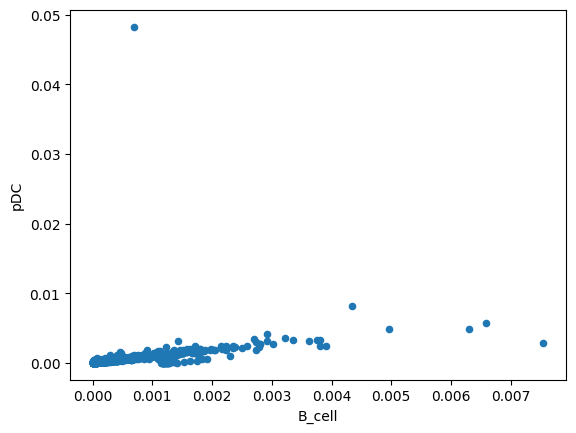

In [17]:
%matplotlib inline
total_effect.plot.scatter(x='B_cell', y='pDC')

### Visualize Cell Type Correlations

Scatter plots showing correlation of predicted effects between cell types:

<Axes: xlabel='B_cell', ylabel='Macrophage'>

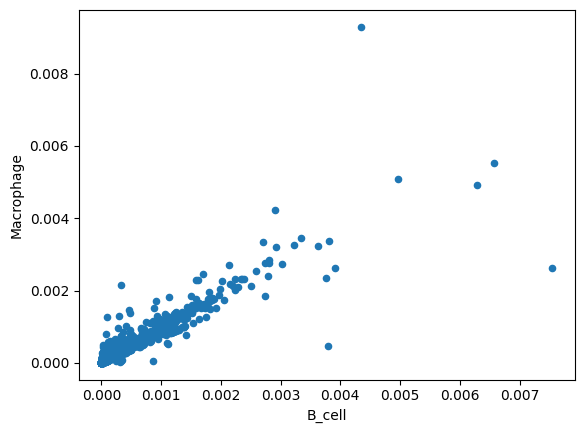

In [18]:
%matplotlib inline
total_effect.plot.scatter(x='B_cell', y='Macrophage')

<Axes: xlabel='pDC', ylabel='Macrophage'>

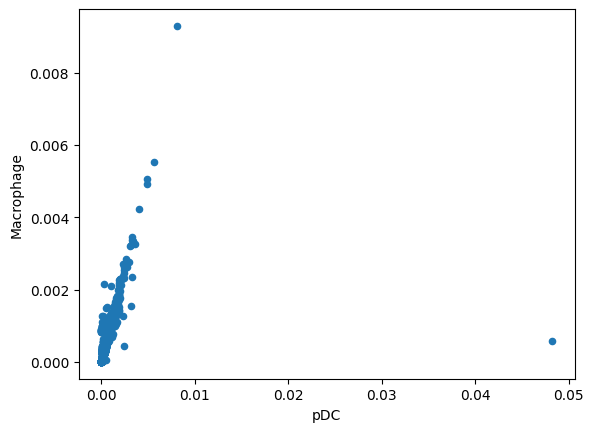

In [19]:
%matplotlib inline
total_effect.plot.scatter(x='pDC', y='Macrophage')

---

## Compare Cell-Type-Specific Responses

A key application of ReCoN is identifying **differential responses** between cell types. This helps understand:
- Which cell types are most affected by a treatment
- Which genes drive cell-type-specific responses
- Potential off-target effects on non-target cell populations

### T cells CD4+ vs B cells

Compare predicted treatment response between T helper cells and B cells:

In [20]:
(total_effect["T_cell_CD4"] - total_effect["B_cell"]).sort_values(ascending=False)[:20]

gene
Fos       0.004969
Map4k1    0.004299
Ctnnb1    0.003570
Myc       0.003014
Ccnd1     0.002946
Arc       0.002888
Sucla2    0.002392
Cr2       0.002220
Ifng      0.002124
Rela      0.001742
Hmox1     0.001735
Il4       0.001699
Cdkn1a    0.001655
Chuk      0.001628
Nfkbia    0.001590
Bcl2l1    0.001563
Mapk9     0.001519
Il1b      0.001379
Egr1      0.001368
Vegfa     0.001333
dtype: float64

```{note}
**Biological interpretation**

Genes with higher scores in T cells CD4+ include known markers like **Cd40lg**, **Cxcr4**, and **Cxcr6** - confirming that ReCoN captures biologically meaningful cell-type-specific signatures.
```

Visualize with a comparison plot highlighting the most differential genes:

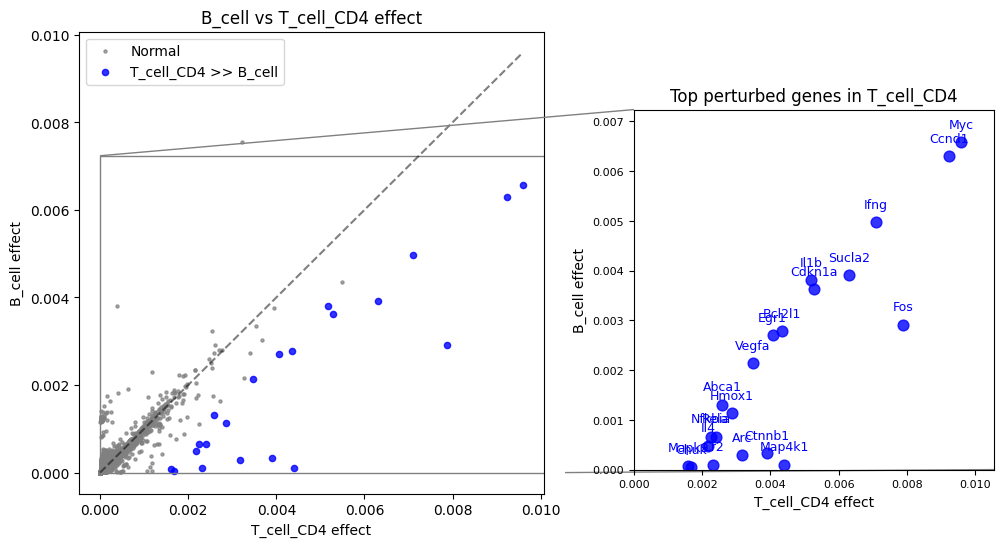

In [21]:
recon.plot.plot_celltype_comparison(total_effect, "T_cell_CD4", "B_cell", quantile=0.998)

### B cells vs T cells CD4+

Now look at genes with higher scores in B cells:

In [22]:
(total_effect["B_cell"] - total_effect["T_cell_CD4"]).sort_values(ascending=False)[:20]

gene
Cd86        0.004334
Dusp4       0.003410
Il1r1       0.001595
Ggh         0.001451
Ebi3        0.001430
Zhx2        0.001403
Il27        0.001391
Sit1        0.001321
Zfp219      0.001284
Actr1b      0.001268
Begain      0.001242
Smpd3       0.001242
Slc25a44    0.001241
Aptx        0.001230
Lipc        0.001223
Asb1        0.001221
Epcam       0.001220
Pmvk        0.001212
Mplkip      0.001203
Tdgf1       0.001192
dtype: float64

```{note}
**Biological interpretation**

Genes with higher expression in B cells include:
- **Cd86**: Marker of antigen presenting cells (including B cells)
- **Ccr6**: Classical marker of B cells, important for germinal center formation

_References:_
1. _Suan D et al. (2017) Immunity 47(6):1142-1153. doi:10.1016/j.immuni.2017.11.022_
2. _Lee AYS & Körner H. (2019) Immunobiology 224(3):449-454. doi:10.1016/j.imbio.2019.01.005_
```

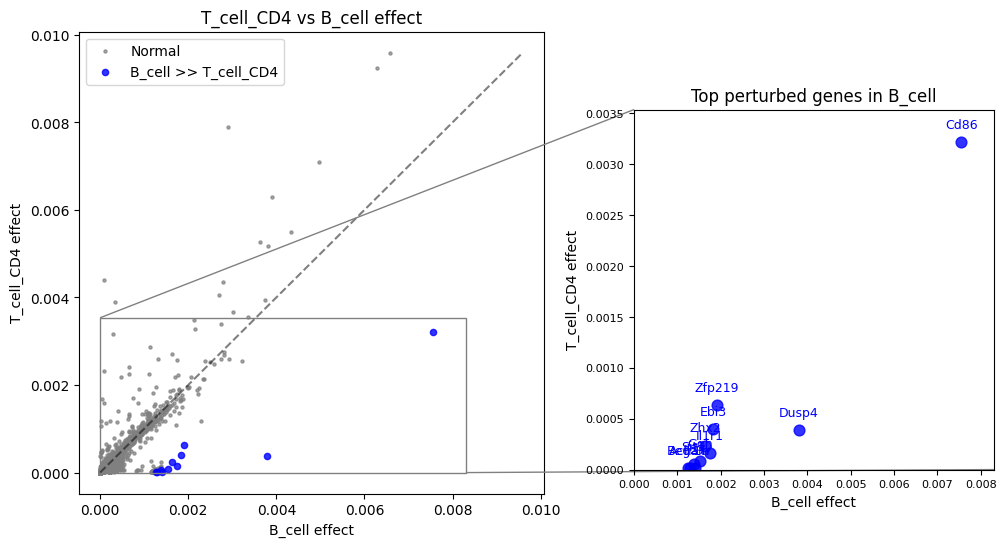

In [28]:
recon.plot.plot_celltype_comparison(total_effect, "B_cell", "T_cell_CD4", quantile=0.999)

### Macrophages vs Other Cell Types

Compare macrophage response to the average of all other cell types:

In [24]:
(total_effect["Macrophage"] - total_effect.loc[:, ~total_effect.columns.isin(["Macrophage"])].mean(1)).sort_values(ascending=False)[:20]

gene
Tnf         0.001129
Ebi3        0.000747
Il1r1       0.000734
Id3         0.000691
Ggh         0.000684
Timp2       0.000655
Il27        0.000654
Zhx2        0.000635
Sit1        0.000621
Arhgap31    0.000620
Actr1b      0.000598
Slc25a44    0.000597
Zfp219      0.000596
Begain      0.000584
Smpd3       0.000579
Aptx        0.000579
Lipc        0.000573
Pmvk        0.000567
Mplkip      0.000567
Asb1        0.000565
dtype: float64

We notice here several known markers of macrophages, innate immunity and tissue remodelling, such as Tnf, Tgfb1, Mmp9

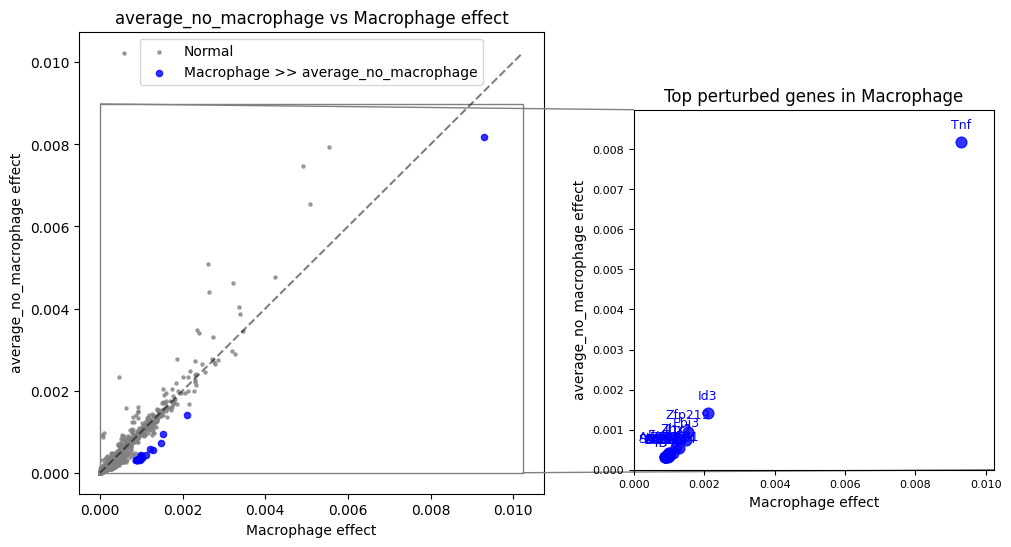

In [25]:
total_effect["average_no_macrophage"] = total_effect.loc[:, ~total_effect.columns.isin(["Macrophage"])].mean(axis=1)
recon.plot.plot_celltype_comparison(total_effect, "Macrophage", "average_no_macrophage", quantile=0.998)
# delete to not include it by mistake later
del total_effect["average_no_macrophage"]

## Gene rank across cell types

We can also compare the rank of each gene across the different cell types:

In [26]:
total_effect.rank().sort_values(by="NK_cell")[:10]

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Ms4a4d,1.0,1.0,1.0,1.0,1.0,1.0
Hist1h2ac,2.0,2.0,2.0,2.0,2.0,2.0
Ifi27l2a,3.0,3.0,3.0,3.0,3.0,3.0
A3galt2,4.0,4.0,4.0,4.0,4.0,4.0
Hus1b,5.0,6.0,6.0,5.0,7.0,5.0
Kantr,6.0,5.0,5.0,6.0,5.0,6.0
Pcdhga6,9.0,7.0,7.0,7.0,6.0,8.0
Sugp1,7.0,9.0,8.0,8.0,10.0,7.0
Trim65,13.0,21.0,12.0,9.0,14.0,9.0


There is often very few changes in-between the highest genes, that are often generic markers and metabolism related genes. </br>
It is usually more interesting to focus on genes of interest (here immune markers)

! Keep in mind for the interpretation that this is the prediction for one specific ligands.</br>

It is thus expected to not retrieve all markers since it does not represent the actual situation of your different cells.

In [27]:
markers = pd.Series([
    "Ptprc",   # pan-leukocyte (CD45)
    "Cd3e", "Trac",              # T cells
    "Cd4", "Cd8a",               # helper vs cytotoxic T
    "Ncr1", "Klrk1",             # NK cells
    "Ms4a1", "Cd19", "Cd79a",    # B cells
    "Sdc1",                      # plasmablasts/plasma cells
    "Lyz2", "Adgre1", "Csf1r",   # monocytes/macrophages
    "Itgax", "Zbtb46",           # conventional dendritic cells
    "Siglech",                   # plasmacytoid dendritic cells
    "Ly6g", "S100a8", "S100a9"   # neutrophils
])

markers = markers[markers.isin(total_effect.index).values]

total_effect.rank(ascending=False).loc[markers].sort_values(by="NK_cell")

celltype_target,B_cell,pDC,Macrophage,NK_cell,T_cell_CD4,T_cell_CD8
gene,,,,,,
Cd4,2391.0,274.0,273.0,53.0,2480.0,60.0
Cd19,492.0,814.0,797.0,398.0,365.0,407.0
S100a8,1304.0,1550.0,1499.0,641.0,787.0,639.0
Csf1r,1419.0,1781.0,586.0,669.0,725.0,655.0
S100a9,1503.0,1587.0,1557.0,696.0,710.0,710.0
Cd79a,876.0,1049.0,1142.0,750.0,757.0,734.0
Sdc1,1505.0,1414.0,1439.0,828.0,709.0,832.0
Itgax,1663.0,1948.0,1903.0,1168.0,1108.0,1095.0
Ptprc,1805.0,1935.0,1919.0,1826.0,1766.0,1606.0


Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
Identifying produced ligands in response to the perturbation.
Seeds are provided as a dictionary with weights per seed.
Creating a multixrank object with seeds as a dictionary.
